In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pycocotools.mask as maskapi
import pickle
import random
from PIL import Image
import scipy.misc
import os
random.seed(224)

In [2]:
dataDir='../coco/'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=40.62s)
creating index...
index created!
118287


In [4]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms)))

In [5]:
# get all images containing person,
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds.sort()
print len(imgIds)
# print imgIds[:400]

64115


In [6]:
def get_mask(imgId, idx=0):
    """Get mask for idx'th person in this imgId."""
    img = coco.loadImgs(imgId)[0]
    filename="%012d.jpg"%imgId
    I = io.imread(dataDir + 'images/' + dataType +'/'+filename) #I = io.imread(img['coco_url'])
    # plt.imshow(I); plt.axis('off')

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=False)
    anns = coco.loadAnns(annIds)
    if idx >= len(anns):
        return None, None

    ann = anns[idx]
    bb = ann['bbox']
    x1, x2, y1, y2 = [int(bb[0]), int(bb[0]+bb[2]), int(bb[1]), int(bb[1]+bb[3])]

    mask=coco.annToMask(ann)
    
    if len(I.shape) < 3:
        # Let's not worry about black and white images.
        return None, None
    img = I[y1:y2, x1:x2, :]
    mask = np.array(mask[y1:y2, x1:x2])
    return img, mask 

def get_iou(mask1, mask2):
    """Get IOU of two binary segmentation masks."""
    rle1 = maskapi.encode(np.asfortranarray(mask1))
    rle2 = maskapi.encode(np.asfortranarray(mask2))
    return maskapi.iou([rle1], [rle2], [0])[0, 0]

def show_im_and_mask(img, mask):
    """Display image and mask."""
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.show()

In [7]:
def get_max_iou(refImgId, refPersonId, personImgIds, numMatches=10):
    """Find the person boxes with best iou with reference imgId and personId."""
    ref_img, ref_mask = get_mask(refImgId, refPersonId)
    ref_h, ref_w, _ = ref_img.shape

    ious = []
    for idx, imgId in enumerate(personImgIds):
        if idx % 10000 == 0 and idx>0:
            print '%d/%d' % (idx, len(personImgIds))
        if imgId == refImgId:
            continue
        # Go over all persons in this image.
        personId = 0
        while True:
            img, mask = get_mask(imgId, personId)
            if img is None:
                # Out of persons in this image.
                break
            # Continue on to next person if size difference is too high.
            # Note: replace this with an input threshold.
            h, w, _ = img.shape
            if h < 0.9 * ref_h or h > 1.1 * ref_h or w < 0.9 * ref_w or w > 1.1 * ref_w:
                personId += 1
                continue
                
            # Find the iou with reference.
            mask = Image.fromarray(mask)
            mask = np.array(mask.resize((ref_w, ref_h), resample=Image.NEAREST), dtype=np.uint8)

            # show_im_and_mask(mask, ref_mask)
            iou = get_iou(ref_mask, mask)
            ious.append((imgId, personId, iou))
            personId += 1  # Go to next person id.
    
    # Get a list of top matches.
    ious = sorted(ious, key=lambda x: x[2], reverse=True)
    ious = ious[:numMatches]

    # Create a list of top match imgs and masks.
    matches = []
    for imgId, personId, iou in ious:
        img, mask = get_mask(imgId, personId)
        img, mask = Image.fromarray(img), Image.fromarray(mask)
        img = np.array(img.resize((ref_w, ref_h)))
        mask = np.array(mask.resize((ref_w, ref_h)))
        matches.append({
            'imgId': imgId,
            'personId': personId,
            'iou': iou,
            'img': img, 
            'mask': mask,
        })

    return matches, ref_img, ref_mask

In [8]:
def get_image(imgId, idx=0):
    """Get mask for idx'th person in this imgId."""
    img = coco.loadImgs(imgId)[0]
    filename="%012d.jpg"%imgId
    I = io.imread(dataDir + 'images/' + dataType +'/'+filename) 

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=False)
    anns = coco.loadAnns(annIds)
    if idx >= len(anns):
        return None, None

    ann = anns[idx]
    mask=coco.annToMask(ann)
    if len(I.shape) < 3:
        # Let's not worry about black and white images.
        return None, None
    return I, mask 

def isrgb(imgId):
    img = coco.loadImgs(imgId)[0]
    filename="%012d.jpg"%imgId
    I = io.imread(dataDir + 'images/' + dataType +'/'+filename) 
    if len(I.shape) < 3:
        return 0
    return 1


def cutpaste(refImgId, refPersonId, target, mask):
#     ref_img, ref_mask = get_mask(refImgId, refPersonId)
    
    img = coco.loadImgs(refImgId)[0]
    filename="%012d.jpg"%refImgId
    I = io.imread(dataDir + 'images/' + dataType +'/'+filename) 
    
    wholemask = np.zeros_like(I) 
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=False)
    anns = coco.loadAnns(annIds)

    ann = anns[refPersonId]
    bb = ann['bbox']
    x1, x2, y1, y2 = [int(bb[0]), int(bb[0]+bb[2]), int(bb[1]), int(bb[1]+bb[3])]  
    
    img = I[y1:y2, x1:x2, :]
    nmask = np.swapaxes(np.swapaxes(np.array([mask,mask,mask]),0,1),1,2)
    wholemask[y1:y2, x1:x2, :]=nmask*255
    
    I[y1:y2, x1:x2, :] = np.multiply(target,nmask) + np.multiply(I[y1:y2, x1:x2, :],1-nmask)
    return I,wholemask

999


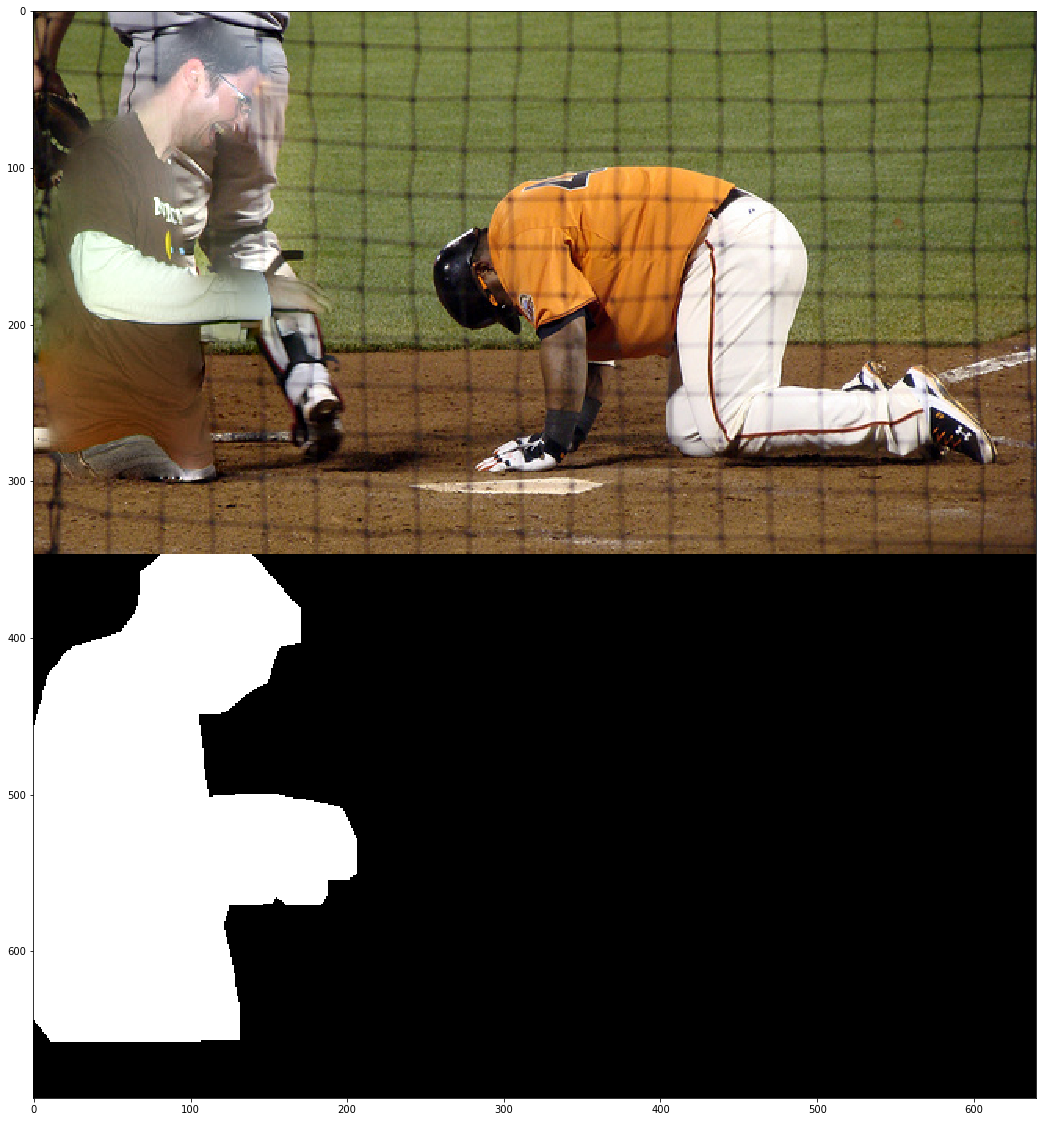

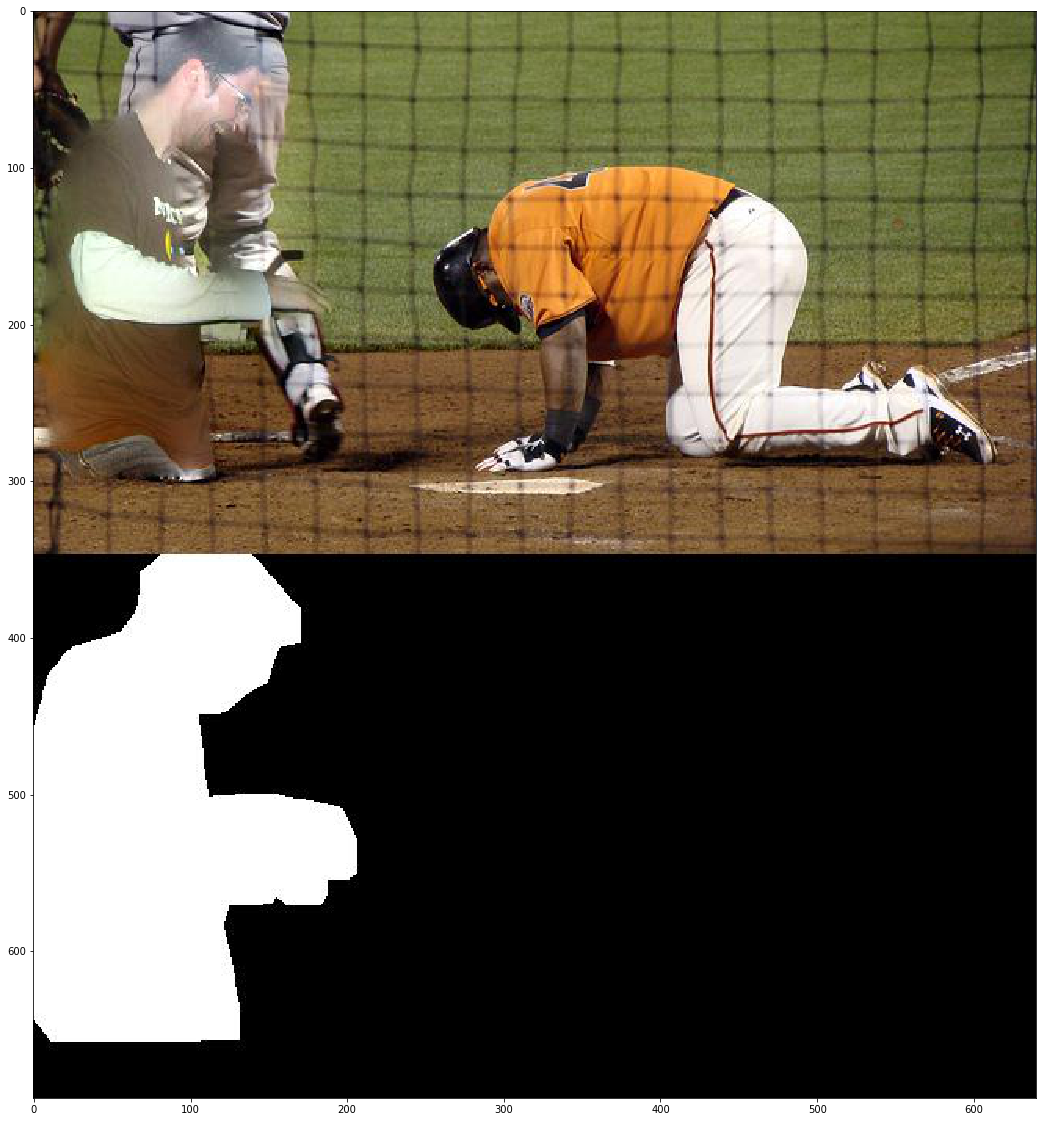

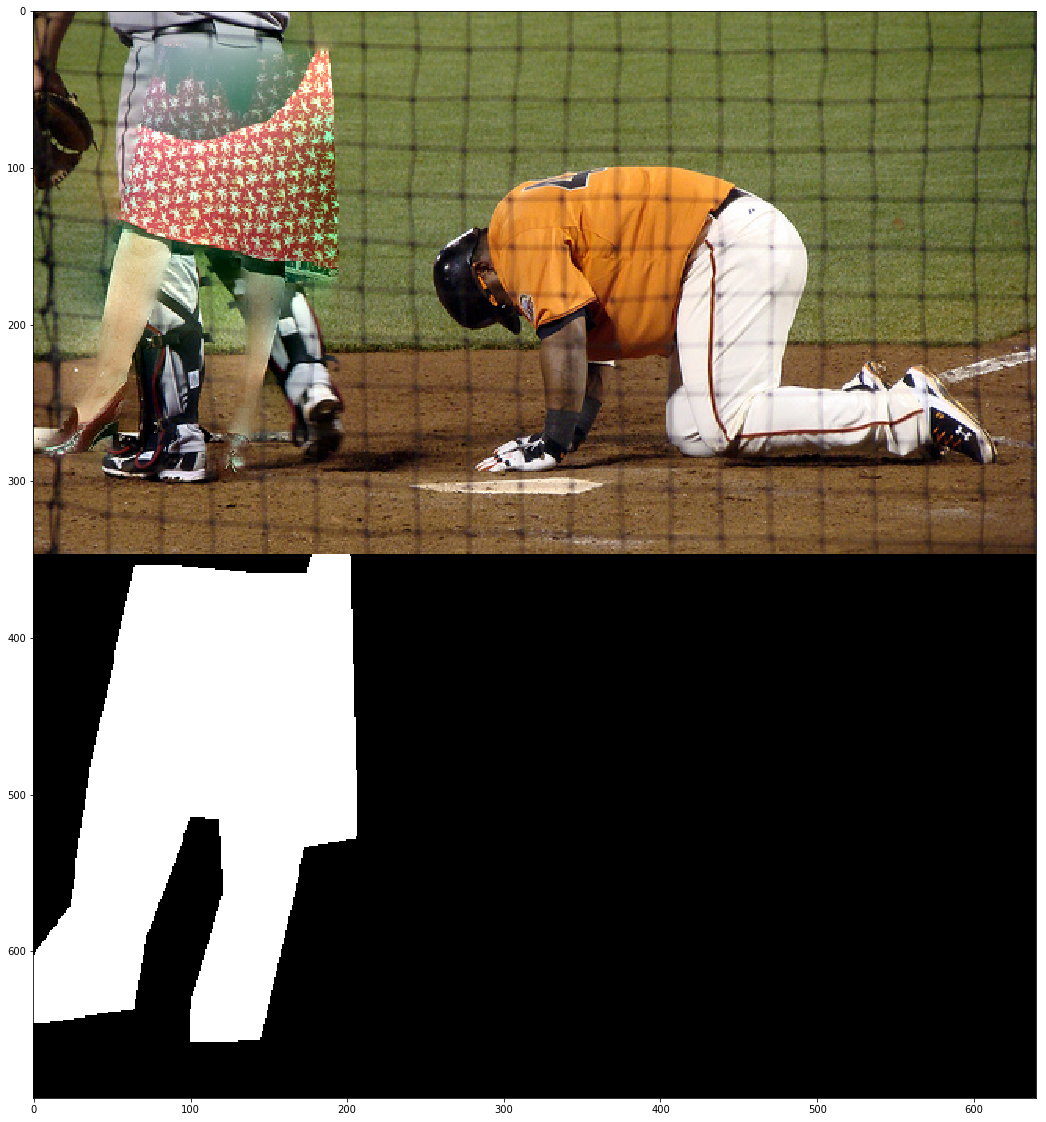

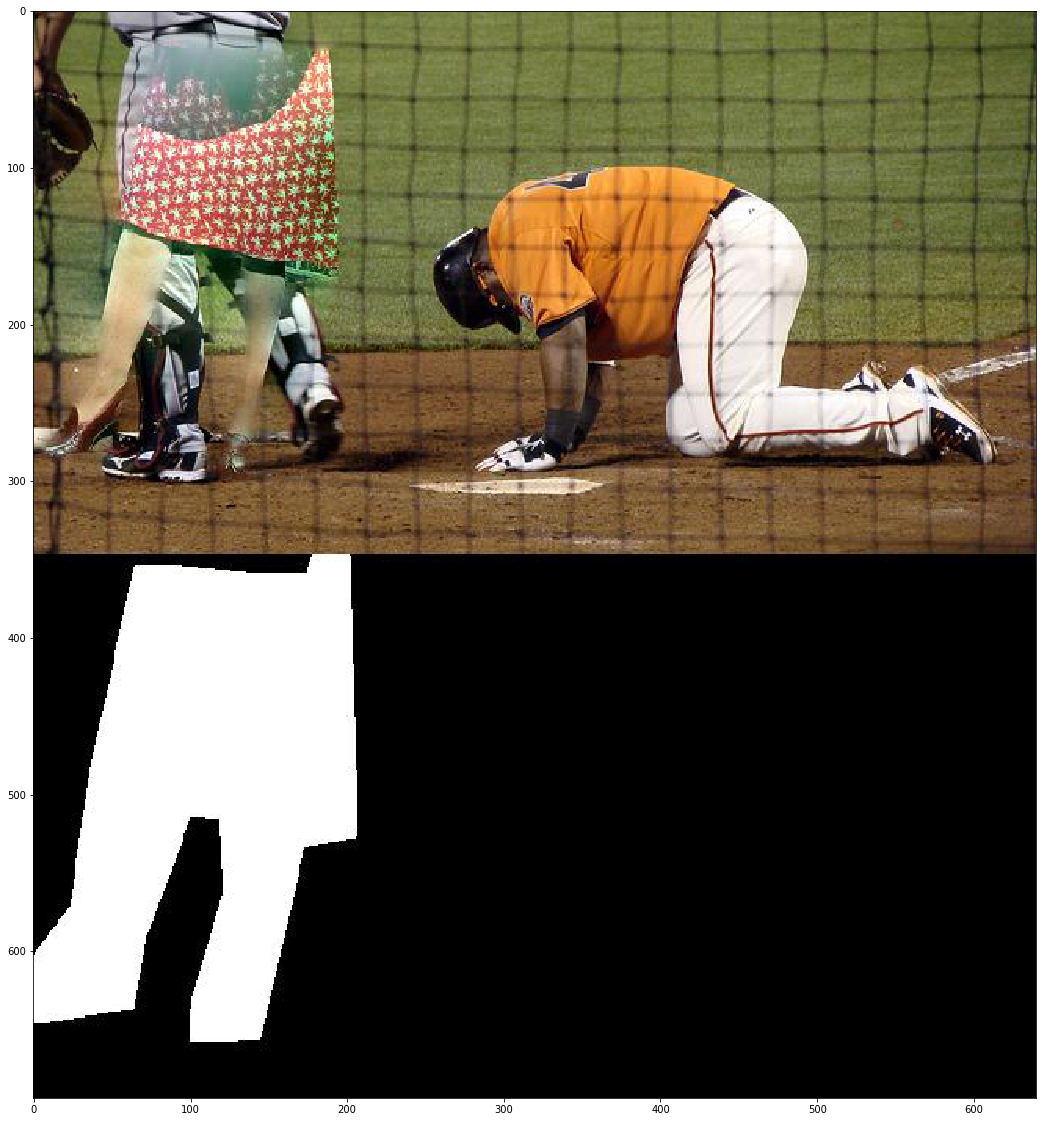

In [13]:
import cv2
from multiprocessing import Pool
N =30

# fil=open('log.txt','w')


def transformimg(img,final,mask):
    minx,maxx,miny,maxy=10000,0,100000,0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j,0]>200:
                minx=min(i,minx)
                maxx=max(i,maxx)
                miny=min(j,miny)
                maxy=max(j,maxy)
                mask[i,j,:]=255
            else:
                mask[i,j,:]=0
    center = ((miny+maxy)/2,(minx+maxx)/2)
#     print(minx,maxx,miny,maxy)
    nmask = mask[minx:maxx,miny:maxy,:]
    src = final[minx:maxx,miny:maxy]
    src= np.multiply(final[minx:maxx,miny:maxy],nmask/255)
    try:
        seamf = cv2.seamlessClone(src,img,nmask,center,cv2.NORMAL_CLONE)
    except cv2.error as e:
        seamf=np.zeros((5,6))
    return seamf


def makeimages(imgId):
#     fil.write(str(imgId)+ ' start ' +'\n') 
    nimgIds = coco.getImgIds(catIds=catIds);
    nimgIds = nimgIds[:N]
    kernel = np.ones((5,5),np.uint8)
    personId = 0
    if isrgb(imgId)==0:
        return
    print(imgId)
    matches, ref_img, ref_mask = get_max_iou(imgId, personId, nimgIds, 10)
    mainimg,_ = get_image(imgId, personId)
                
#     scipy.misc.imsave('./maskdata/real/'+str(imgId)+'.jpg', mainimg)
    for idx, match in enumerate(matches):
#         print 'Rank: %d, iou: %.2f' % (idx + 1, match['iou'])
        final,wholemask=cutpaste(imgId, personId, match['img'], match['mask'])  
#         print(imgId)
        final=transformimg(mainimg,final,wholemask)
        if final.shape[0]==5 and final.shape[1]==6 :
            break
        wholemask = cv2.dilate(wholemask,kernel,iterations = 5)      
        finalwithmask = np.concatenate((final,wholemask),axis=0)
        plt.figure( figsize=(20, 20))
        plt.imshow(finalwithmask)
#         size = (finalwithmask.shape[0])/2
#         tmimg,tmmask = finalwithmask[:size,:,:].astype('uint8'),finalwithmask[size:,:,:]
        scipy.misc.imsave('./try.jpg', finalwithmask)
        I= io.imread('./try.jpg')
        plt.figure( figsize=(20, 20))
        plt.imshow(I)
#     fil.write(str(imgId)+ ' end ' +'\n') 

makeimages(999)
# rimgIds = [536,4478,999,1407,36,1875]
# rimgIds = imgIds[:N]
# pool = Pool(processes=35)
# pool.map(makeimages,rimgIds)